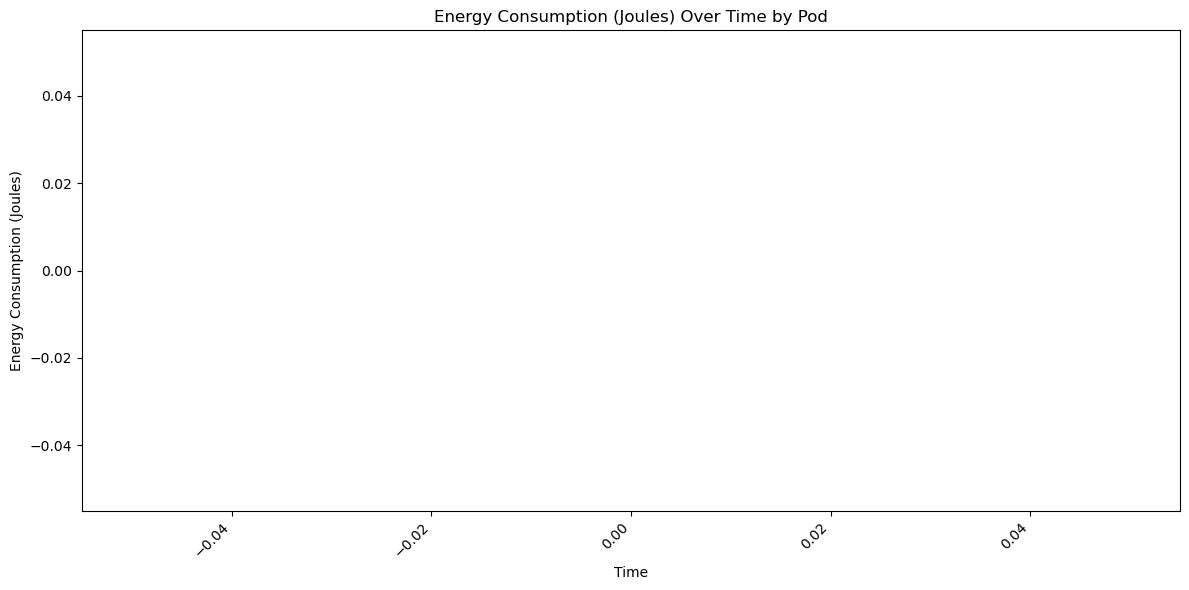

In [46]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Step 1: Fetch Prometheus query data
PROMETHEUS_URL = "http://localhost:9090"  # Replace with your Prometheus API URL

# Define the query (without rate, just total consumption)
QUERY = 'kepler_container_core_joules_total{container_namespace="kubeflow", namespace="kepler", pod_name=~".*anonymize.*"}'

# Define the time range for the query
start_time = datetime.datetime(2024, 12, 20, 9, 40)  # Start time (example)
end_time = datetime.datetime(2024, 12, 20, 9, 59)  # End time (example)
step = "30s"  # Time step (e.g., 1 minute)

# Convert start and end times to Unix timestamps
start_timestamp = int(start_time.timestamp())
end_timestamp = int(end_time.timestamp())

# Query Prometheus API using query_range to get time range data
response = requests.get(
    f"{PROMETHEUS_URL}/api/v1/query_range",
    params={"query": QUERY, "start": start_timestamp, "end": end_timestamp, "step": step}
)
data = response.json()

# Step 2: Parse the results into a Pandas DataFrame
results = data['data']['result']

# Extract pod names, joule values, and timestamps
pod_names = [result['metric'].get('pod_name', 'unknown') for result in results]
joule_values = [float(result['value'][1]) for result in results]
timestamps = [int(result['value'][0]) for result in results]  # Timestamps in Unix time

# Convert timestamps to human-readable times and round to 1-minute intervals
times = [datetime.datetime.fromtimestamp(ts).replace(second=0, microsecond=0) for ts in timestamps]

# Extract the last part of the pod name
def extract_last_part(name):
    return name.split("-")[-1]

pod_labels = [extract_last_part(pod_name) for pod_name in pod_names]

# Create a DataFrame
df = pd.DataFrame({
    'Time': times,
    'Pod Name': pod_names,
    'Joules': joule_values,
    'Pod Label': pod_labels
})

# Step 3: Aggregate Data by Time Interval (Group by Time and Pod Name)
df_agg = df.groupby(['Time', 'Pod Name', 'Pod Label']).sum().reset_index()

# Step 4: Assign a unique color for each pod name
unique_pods = df_agg['Pod Name'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_pods)))
pod_color_map = {pod: colors[i] for i, pod in enumerate(unique_pods)}

# Step 5: Plot the bar chart
plt.figure(figsize=(12, 6))

# Plot bars grouped by time
bars = plt.bar(
    df_agg['Time'].astype(str), df_agg['Joules'], 
    color=[pod_color_map[pod] for pod in df_agg['Pod Name']]
)

# Add labels (last part of pod name) on top of the bars
for bar, label in zip(bars, df_agg['Pod Label']):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.1, 
        label, ha='center', va='bottom', fontsize=8
    )

# Customize the plot
plt.title("Energy Consumption (Joules) Over Time by Pod")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (Joules)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/vk/d03r7hzd5p9c3zdtvt3xrhc40000gn/T/ipykernel_51577/4121108013.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


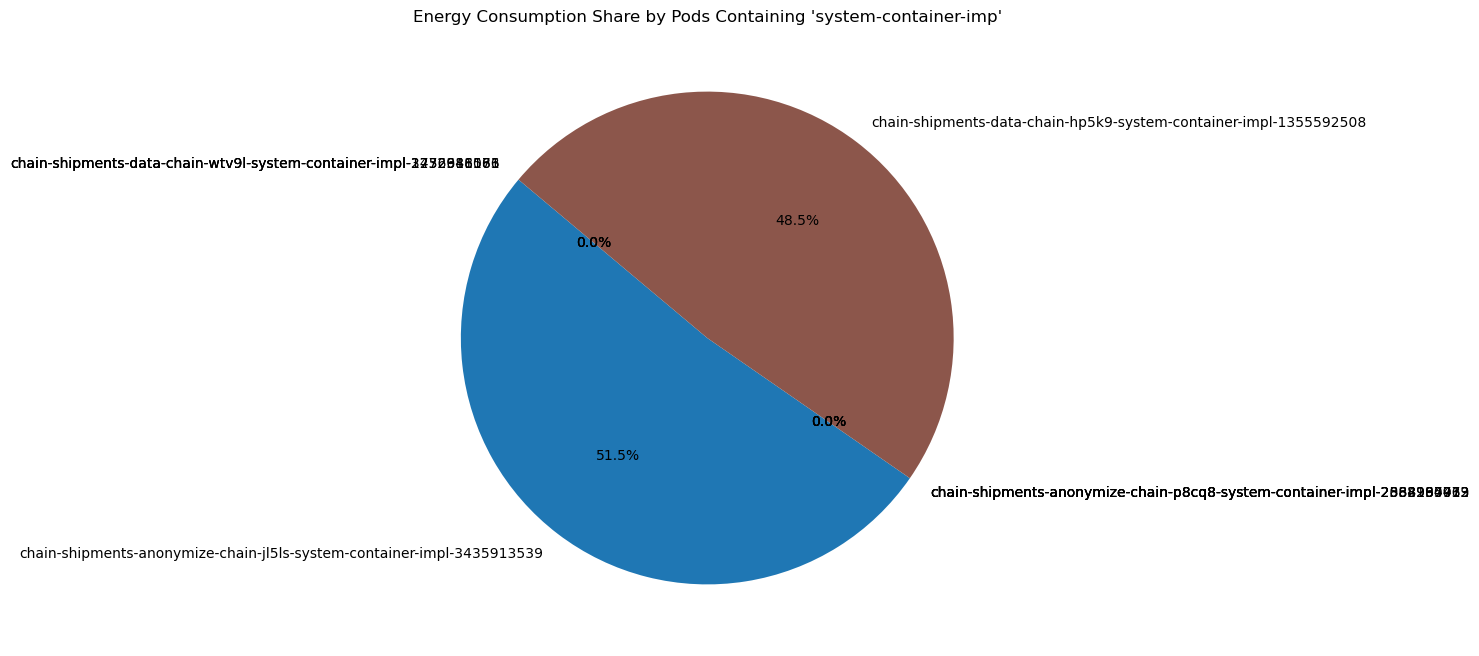

In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fetch Prometheus query data
PROMETHEUS_URL = "http://localhost:9090"  # Replace with your Prometheus API URL
QUERY = 'rate(kepler_container_core_joules_total{container_namespace="kubeflow", namespace="kepler", pod_name=~".*system-container-imp.*"}[5m])'

# Query Prometheus API
response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={"query": QUERY})
data = response.json()

# Step 2: Parse the results into a Pandas DataFrame
results = data['data']['result']

# Extract pod names and their joule values
pod_names = [result['metric'].get('pod_name', 'unknown') for result in results]
joule_values = [float(result['value'][1]) for result in results]

# Create a DataFrame
df = pd.DataFrame({
    'Pod Name': pod_names,
    'Joules': joule_values
})

# Step 3: Group by pod name (in case of duplicates) and sum joule values
df = df.groupby('Pod Name', as_index=False).sum()

# Step 4: Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['Joules'], labels=df['Pod Name'], autopct='%1.1f%%', startangle=140)
plt.title("Energy Consumption Share by Pods Containing 'system-container-imp'")
plt.tight_layout()

# Show the plot
plt.show()


{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {'container': 'kepler-exporter', 'container_id': 'b86137db9b5b2c87634f87d5e610a11a7b74e47ba0a2e9a4edef7af9c0a17c3b', 'container_name': 'init', 'container_namespace': 'kubeflow', 'endpoint': 'http', 'instance': 'k3d-k3d-kubeflow-cluster-agent-1', 'job': 'kepler', 'mode': 'dynamic', 'namespace': 'kepler', 'pod': 'kepler-kdd2n', 'pod_name': 'chain-shipments-anonymize-chain-fb44z-system-container-impl-2351548805', 'service': 'kepler', 'source': 'trained_power_model'}, 'value': [1734724119.675, '0']}, {'metric': {'container': 'kepler-exporter', 'container_id': '82956879179754b54802a7eaf27e89771b4cd6ca97558617aa8ac55da76c700c', 'container_name': 'kfp-launcher', 'container_namespace': 'kubeflow', 'endpoint': 'http', 'instance': 'k3d-k3d-kubeflow-cluster-agent-1', 'job': 'kepler', 'mode': 'dynamic', 'namespace': 'kepler', 'pod': 'kepler-kdd2n', 'pod_name': 'chain-shipments-anonymize-chain-fb44z-system-container-impl-2

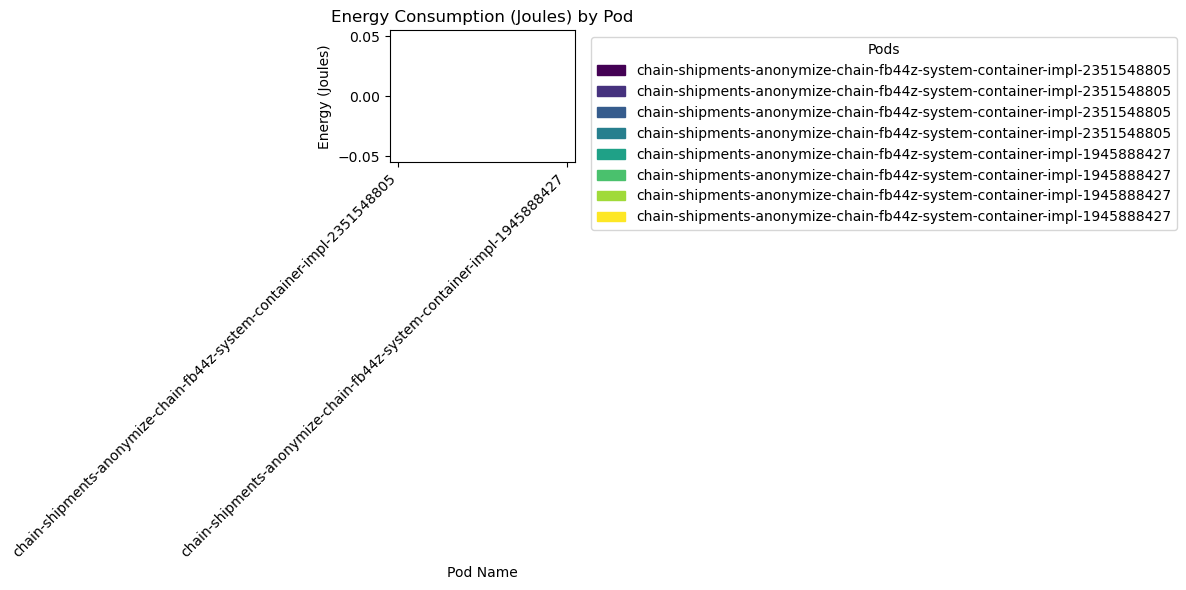

In [50]:
# Bar Plots

import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Fetch Prometheus query data
PROMETHEUS_URL = "http://localhost:9090"  # Replace with your Prometheus API URL
QUERY = 'rate(kepler_container_core_joules_total{container_namespace="kubeflow", namespace="kepler", pod_name=~".*system-container-imp.*"}[5m])'


# Query Prometheus API
response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={"query": QUERY})
data = response.json()
print(data)

# Step 2: Parse the results into a Pandas DataFrame
results = data['data']['result']

# Extract pod names and their joule values
pod_names = [result['metric'].get('pod_name', 'unknown') for result in results]
joule_values = [float(result['value'][1]) for result in results]

# Create a DataFrame
df = pd.DataFrame({
    'Pod Name': pod_names,
    'Joules': joule_values
})

# Step 3: Generate different colors for each pod
num_pods = len(df)
colors = plt.cm.viridis(np.linspace(0, 1, num_pods))  # Viridis colormap for distinct colors

# Step 4: Plot the area chart with different colors
plt.figure(figsize=(12, 6))
df = df.sort_values(by="Joules", ascending=False)  # Optional: sort by joule values
df.set_index('Pod Name', inplace=True)

# Plot each pod with its own color
for i, (pod, joule) in enumerate(df.iterrows()):
    plt.fill_between([pod], 0, joule, color=colors[i], label=pod)

# Customize the chart
plt.title("Energy Consumption (Joules) by Pod")
plt.xlabel("Pod Name")
plt.ylabel("Energy (Joules)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Pods", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add a legend
plt.tight_layout()

# Show the plot
plt.show()


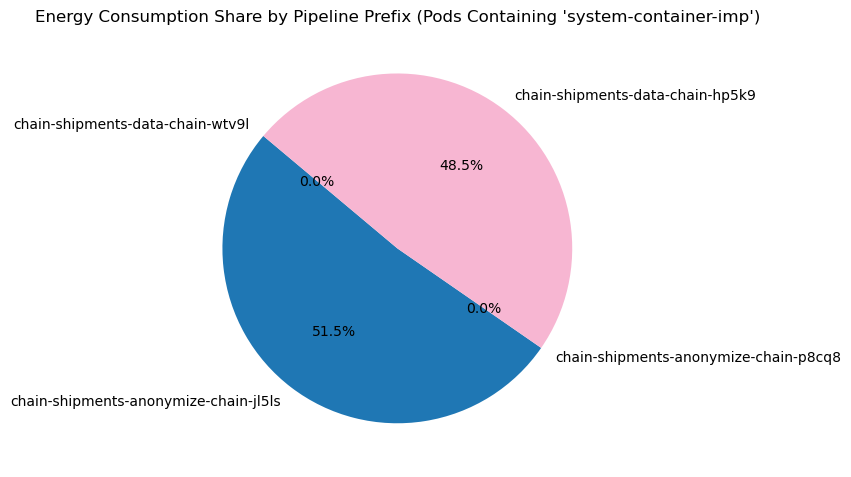

In [24]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Step 1: Fetch Prometheus query data
PROMETHEUS_URL = "http://localhost:9090"  # Replace with your Prometheus API URL
QUERY = 'rate(kepler_container_core_joules_total{container_namespace="kubeflow", namespace="kepler", pod_name=~".*system-container-imp.*"}[5h])'

# Query Prometheus API
response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={"query": QUERY})
data = response.json()

# Step 2: Parse the results into a Pandas DataFrame
results = data['data']['result']

# Extract pod names and their joule values
pod_names = [result['metric'].get('pod_name', 'unknown') for result in results]
joule_values = [float(result['value'][1]) for result in results]

# Extract the prefix before "system-container-imp"
def extract_pipeline_prefix(pod_name):
    if "system-container-imp" in pod_name:
        return pod_name.split("system-container-imp")[0].rstrip("-")  # Extract everything before "system-container-imp"
    return pod_name  # If not found, return the original pod_name

# Create a DataFrame
df = pd.DataFrame({
    'Pod Name': pod_names,
    'Joules': joule_values
})

# Step 3: Add a new column for pipeline_prefix extracted from pod_name
df['Pipeline Prefix'] = df['Pod Name'].apply(extract_pipeline_prefix)

# Step 4: Group by pipeline_prefix and sum joule values
df_grouped = df.groupby('Pipeline Prefix', as_index=False).sum()

# Step 5: Create a color map for each pipeline_prefix
unique_prefixes = df_grouped['Pipeline Prefix'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_prefixes)))  # Using tab20 colormap
pipeline_color_map = {prefix: colors[i] for i, prefix in enumerate(unique_prefixes)}

# Step 6: Plot the pie chart
plt.figure(figsize=(8, 8))

# Plot pie chart with the same color for the same pipeline_prefix
plt.pie(df_grouped['Joules'], labels=df_grouped['Pipeline Prefix'], autopct='%1.1f%%', startangle=140, colors=[pipeline_color_map[prefix] for prefix in df_grouped['Pipeline Prefix']])

plt.title("Energy Consumption Share by Pipeline Prefix (Pods Containing 'system-container-imp')")
plt.tight_layout()

# Show the plot
plt.show()
